# Miniproject: Landing on the Moon

## Introduction

### Description

Traditionally, reinforcement learning has operated on "tabular" state spaces, e.g. "State 1", "State 2", "State 3" etc. However, many important and interesting reinforcement learning problems (like moving robot arms or playing Atari games) are based on either continuous or very high-dimensional state spaces (like robot joint angles or pixels). Deep neural networks constitute one method for learning a value function or policy from continuous and high-dimensional observations. 

In this miniproject, you will teach an agent to play the Lunar Lander game from [OpenAI Gym](https://gym.openai.com/envs/LunarLander-v2/). The agent needs to learn how to land a lunar module safely on the surface of the moon. The state space is 8-dimensional and (mostly) continuous, consisting of the X and Y coordinates, the X and Y velocity, the angle, and the angular velocity of the lander, and two booleans indicating whether the left and right leg of the lander have landed on the moon.

The agent gets a reward of +100 for landing safely and -100 for crashing. In addition, it receives "shaping" rewards at every step. It receives positive rewards for moving closer to [0,0], decreasing in velocity, shifting to an upright angle and touching the lander legs on the moon. It receives negative rewards for moving away from the landing site, increasing in velocity, turning sideways, taking the lander legs off the moon and for using fuel (firing the thrusters). The best score an agent can achieve in an episode is about +250.

There are two versions of the task: one with discrete controls and one with continuous controls but we'll only work with the discrete version. In the discrete version, the agent can take one of four actions at each time step: [do nothing, fire engines left, fire engines right, fire engines down]. 

We will use Policy Gradient approaches (using the REINFORCE rule) to learn the task. As you remember, in standard supervised learning tasks (e.g. image classification), the network generates a probability distribution over the outputs, and is trained to maximize the probability of a specific target output given an observation (input). In Policy Gradient methods, the network generates a probability distribution over actions, and is trained to maximize expected future rewards given an observation.

### Questions
**Question 1**. Suppose that you are designing the environment rewards yourself. Why do you think it is a good idea to have rewards in addition to the +100 reward for safe landing (e.g. for moving closer / further from [0, 0], for touching the lander legs on the moon)? One might say that if we only have a final reward, the agent will still be able to learn how to reach it. What will be the problem here?

**Answer**: We learn faster as the rewards are less sparse. With a reward at then end the agent will be able to learn but it will take it longer.


**Question 2**. Now suppose you decide to give the agent a small reward if it moves closer to the landing point but you forget to penalize it when it moves away from it. What kinds of strange behaviour you may observe from the trained agent?

**Answer**: The agent will move back and forth from the landing point (but without landing) as this will make its reward greater and greater.


### Prerequisites

- You will need to install [Miniconda](https://docs.conda.io/en/latest/miniconda.html) and run the following commands:

  - conda create -n cs456env python=3.7.2
  - source activate cs456env
  - pip install gym[Box2D]
  - pip install ipykernel
  - pip install tensorflow
  - pip install keras
  - pip install matplotlib
  
- You should know the concepts of "policy", "policy gradient", "REINFORCE", "REINFORCE with baseline". If you want to start and haven't seen these yet in class, read Sutton & Barto (2018) Chapter 13 (13.1-13.4).

### What you will learn

- You will learn how to implement a policy gradient neural network using the REINFORCE algorithm.
- You will learn how to implement baselines, including a learned value network.
- You will learn how to analyze the performance of an RL algorithm.

### Notes 
- Reinforcement learning is noisy! Normally one should average over multiple random seeds with the same parameters to really see the impact of a change to the model, but we won't do this due to time constraints. However, you should be able to see learning over time with every approach. If you don't see any improvement, or very unstable learning, double-check your model and try adjusting the learning rate.

- You may sometimes see `AssertionError: IsLocked() = False` after restarting your code. To fix this, reinitialize the environments by running the Gym Setup code below.

- You will not be marked on the episode movies. Please delete these movies before uploading your code.

### Evaluation criteria

The miniproject is marked out of 18, with a further mark breakdown in each question:
- Exercise 1: 7 points
- Exercise 2: 3 points
- Exercise 3: 3 points
- Exercise 4: 5 points

We may perform random tests of your code but will not rerun the whole notebook.

In [1]:
# doesn't work in jupyter lab
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Your Names

Before you start, please enter your sciper number(s) in the field below; they are used to load the data.

In [2]:
sciper = {'Sylvain Lugeon': 270920, 
          'Paul Griesser': 274918}
seed = sciper['Sylvain Lugeon']+sciper['Paul Griesser']

## Setup

### Dependencies and constants

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import logging
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output
from gym.envs.box2d.lunar_lander import heuristic

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.optimizers import Adam
from keras import backend as K

np.random.seed(seed)
tf.random.set_seed(seed*2)

In [8]:
# Checking versions
from platform import python_version
print('Python: ' + python_version())
print('Tensorflow: ' + tf.__version__)
print('Keras: ' + keras.__version__)

Python: 3.8.8
Tensorflow: 2.4.0
Keras: 2.4.3


In [10]:
render_landing = False # if we want to render the simulation, false for speed-up
training = True # load results if false, else train and overwrite
plot_window = 50 

### Gym Setup

Here we load the Reinforcement Learning environments from Gym.

We limit each episode to 500 steps so that we can train faster. 

In [11]:
gym.logger.setLevel(logging.ERROR)
discrete_env = gym.make('LunarLander-v2')
discrete_env._max_episode_steps = 500
discrete_env.seed(seed*3)
gym.logger.setLevel(logging.WARN)

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams["animation.html"] = "jshtml"

### Utilities

We include a function that lets you visualize an "episode" (i.e. a series of observations resulting from the actions that the agent took in the environment).

As well, we will use the `Results` class (a wrapper around a python dictionary) to store, save, load and plot your results. You can save your results to disk with `results.save('filename')` and reload them with `Results(filename='filename')`. Use `results.pop(experiment_name)` to delete an old experiment.

In [12]:
def AddValue(output_size, value):
    return Lambda(lambda x: x + value, output_shape=(output_size,))

def render(episode, env):
    
    fig = plt.figure()
    img = plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    def animate(i):
        img.set_data(episode[i])
        return img,

    anim = FuncAnimation(fig, animate, frames=len(episode), interval=24, blit=True)
    html = HTML(anim.to_jshtml())
    
    plt.close(fig)
    !rm None0000000.png
    
    return html

class Results(dict):
    
    def __init__(self, *args, **kwargs):
        if 'filename' in kwargs:
            data = np.load(kwargs['filename'])
            super().__init__(data)
        else:
            super().__init__(*args, **kwargs)
        self.new_key = None
        self.plot_keys = None
        self.ylim = None
        
    def __setitem__(self, key, value):
        super().__setitem__(key, value)
        self.new_key = key

    def plot(self, window):
        clear_output(wait=True)
        for key in self:
            #Ensure latest results are plotted on top
            if self.plot_keys is not None and key not in self.plot_keys:
                continue
            elif key == self.new_key:
                continue
            self.plot_smooth(key, window)
        if self.new_key is not None:
            self.plot_smooth(self.new_key, window)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc='lower right')
        if self.ylim is not None:
            plt.ylim(self.ylim)
        plt.show()
        
    def plot_smooth(self, key, window):
        if len(self[key]) == 0:
            plt.plot([], [], label=key)
            return None
        y = np.convolve(self[key], np.ones((window,))/window, mode='valid')
        x = np.linspace(window/2, len(self[key]) - window/2, len(y))
        plt.plot(x, y, label=key)
        
    def save(self, filename='results'):
        np.savez(filename, **self)

### Test runs

To get an idea of how the environment works, we'll plot an episode resulting from random actions at each point in time, and a "perfect" episode using a specially-designed function to land safely within the yellow flags. 

Please remove these plots before submitting the miniproject to reduce the file size.

In [13]:
def run_fixed_episode(env, policy):
    frames = []
    observation = env.reset()
    done = False
    while not done:
        frames.append(env.render(mode='rgb_array'))
        action = policy(env, observation)
        observation, reward, done, info = env.step(action)
    return frames
    
def random_policy(env, observation):
    return env.action_space.sample()

def heuristic_policy(env, observation):
    return heuristic(env.unwrapped, observation)

In [14]:
if render_landing:
    episode = run_fixed_episode(discrete_env, random_policy)
    render(episode, discrete_env)

In [15]:
if render_landing:
    episode = run_fixed_episode(discrete_env, heuristic_policy)
    render(episode, discrete_env)

## Experiment Loop

This is the method we will call to setup an experiment. Reinforcement learning usually operates on an Observe-Decide-Act cycle, as you can see below.

You don't need to add anything here; you will be working directly on the RL agent.

In [17]:
num_episodes = 3000

def run_experiment(experiment_name, env, num_episodes, 
                   policy_learning_rate=0.001, value_learning_rate=0.001, 
                   baseline=None, 
                   policy_num_layers=3, value_num_layers=3,
                   policy_width=16, value_width=16):

    #Initiate the learning agent
    agent = RLAgent(env.observation_space.shape[0], 
                    env.action_space,
                    policy_learning_rate, 
                    value_learning_rate, 
                    policy_num_layers,
                    value_num_layers,
                    policy_width,
                    value_width,
                    baseline)

    rewards = []
    all_episode_frames = []
    step = 0
    for episode in range(1, num_episodes+1):
    
        # Update results plot and occasionally store an episode movie
        episode_frames = None
        if episode % 10 == 0:
            results[experiment_name] = np.array(rewards)
            results.plot(10)

        if episode % 500 == 0 and render_landing:
            episode_frames = []
            
        # Reset the environment to a new episode
        observation = env.reset()
        episode_reward = 0

        while True:
        
            if episode_frames is not None:
                episode_frames.append(env.render(mode='rgb_array'))

            # 1. Decide on an action based on the observations
            action = agent.decide(observation)

            # 2. Take action in the environment
            next_observation, reward, done, info = env.step(action)
            episode_reward += reward

            # 3. Store the information returned from the environment for training
            agent.observe(observation, action, reward)

            # 4. When we reach a terminal state ("done"), use the observed episode to train the network
            if done:
                rewards.append(episode_reward)
                if episode_frames is not None:
                    all_episode_frames.append(episode_frames)
                agent.train()
                break

            # Reset for next step
            observation = next_observation
            step += 1
            
    return all_episode_frames, agent

## The Agent

Here we give the outline of a python class that will represent the reinforcement learning agent (along with its decision-making network). We'll modify this class to add additional methods and functionality throughout the course of the miniproject.


In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical 

class RLAgent(object):
    
    def __init__(self, n_obs, action_space, 
                 policy_learning_rate, value_learning_rate, 
                 policy_num_layers, value_num_layers, 
                 policy_width, value_width, 
                 baseline, discount=0.99):

        # We need the state and action dimensions to build the network
        self.n_obs = n_obs  
        self.n_act = action_space.n
        
        self.plr = policy_learning_rate
        self.vlr = value_learning_rate
        self.gamma = discount
        self.policy_num_layers = policy_num_layers
        self.value_num_layers = value_num_layers
        
        self.policy_model = None
        self.value_model = None
        
        self.units_pol_model = policy_width # nb of hidden neurons per layer in the policy model
        self.units_val_model = value_width # nb of hidden neurons per layer in the value model
        
        
        self.baseline = baseline
        self.mean_rewards = [] # stores the mean reward of each episode
        self.window = 50 # window of moving average
        

        # These lists stores the cumulative observations for this episode
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []

        # Build the keras network
        self._build_network()

    def observe(self, state, action, reward):
        """ This function takes the observations the agent received from the environment and stores them
            in the lists above."""
        self.episode_observations.append(state)
        self.episode_actions.append(action)
        self.episode_rewards.append(reward)
        
    def decide(self, state):
        """ This function feeds the observed state to the network, which returns a distribution
            over possible actions. Sample an action from the distribution and return it."""
        output = self.policy_model(state[np.newaxis, ...]).numpy()
        action = np.random.choice(self.n_act, p=output.flatten()) # choose random action given probabilities
        
        return action
        

    def train(self):
        """ When this function is called, the accumulated episode observations, actions and discounted rewards
            should be fed into the network and used for training. Use the _get_returns function to first turn 
            the episode rewards into discounted returns. 
            Apply simple or adaptive baselines if needed, depending on parameters."""
        
        inputs = np.vstack(self.episode_observations)
        targets = to_categorical(self.episode_actions, num_classes=self.n_act)
        rewards, gammas = self._get_returns()
            
        # baseline is a moving average of mean reward of the previous episode
        if self.baseline == 'simple':
            self.mean_rewards.append(rewards.mean())
            n_previous = min(self.window, len(self.mean_rewards))
            if n_previous > 0:
                rewards = rewards - np.mean(self.mean_rewards[-n_previous:])
        
        # baseline is the estimated v-value for each state
        if self.baseline == 'adaptive':
            self.value_model.train_on_batch(inputs, rewards, sample_weight=gammas) # weighted by gammas, as in slide 96
            predicted_rewards = self.value_model(inputs).numpy().flatten()
            rewards  = rewards - predicted_rewards
                
        self.policy_model.train_on_batch(inputs, targets, sample_weight=gammas*rewards) # weighted by gammas, as in slide 96
                
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []
        
    

    def _get_returns(self):
        """ This function should process self.episode_rewards and return the discounted episode returns
            at each step in the episode. Hint: work backwards."""
        ep_duration = len(self.episode_rewards)
        gammas = np.array(ep_duration*[self.gamma]) ** np.arange(ep_duration) # discounts for each timestep
        disc_rewards = gammas * self.episode_rewards # discounts reward (from the start)
        cum_rewards = np.cumsum(disc_rewards[::-1])[::-1] # cumulative rewards
        returns = cum_rewards / gammas # shift the starting point
        return returns, gammas 
    
    
    def _build_policy_model(self):
        
        self.policy_model = Sequential()
        
        # if there is no hidden layers, we add a single dense layer
        if self.policy_num_layers == 1:
            self.policy_model.add(Dense(self.n_act, input_dim=self.n_obs, activation='softmax'))
        
        else:
            self.policy_model.add(Dense(self.units_pol_model, input_dim=self.n_obs, activation='relu'))
            
            for i in range(self.policy_num_layers-2):
                self.policy_model.add(Dense(self.units_pol_model, activation='relu'))
                
            self.policy_model.add(Dense(self.n_act, activation='softmax')) # softmax activation at the end
            
        self.policy_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.plr))
        
    def _build_value_model(self):
        
        self.value_model = Sequential()
        
        # if there is no hidden layers, we add a single dense layer
        if self.value_num_layers == 1:
            self.value_model.add(Dense(1, input_dim=self.n_obs, activation='softmax'))
        
        else:
            self.value_model.add(Dense(self.units_val_model, input_dim=self.n_obs, activation='relu'))
            
            for i in range(self.value_num_layers-2):
                self.value_model.add(Dense(self.units_val_model, activation='relu'))
                
            self.value_model.add(Dense(1)) # no activation
            
        self.value_model.compile(loss='mse', optimizer=Adam(lr=self.vlr))
        
        

    def _build_network(self):
        """ This function should build the network that can then be called by decide and train. 
            The network takes observations as inputs and has a policy distribution as output."""
                                 
        self._build_policy_model()
        
        if self.baseline == 'adaptive':
            self._build_value_model()
        

## Exercise 1: REINFORCE with simple baseline

### Description

Implement the REINFORCE Policy Gradient algorithm using a deep neural network as a function approximator.

1. Implement the `observe` method of the RLAgent above.
2. Implement the `_build_network` method. Your network should take the 8-dimensional state space as input and output a softmax distribution over the 4 discrete actions. It should have 3 hidden layers with 16 units each with ReLU activations. Use the REINFORCE loss function. HINT: Keras has a built-in "categorical cross-entropy" loss, and a `sample_weight` argument in fit/train_on_batch. Consider how these could be used together.
3. Implement the `decide`, `train` and `_get_returns` methods using the inputs and outputs of your network. In `train`, implement a baseline based on a moving average (over episodes) of the mean returns (over trials of one episode); it should only be in effect when the agent is constructed with the `use_simple_baseline` keyword. Also, use `train_on_batch` to form one minibatch from all the experiences in an episode. Hint: see Question 2) below.
4. Try a few learning rates and pick the best one (the default for Adam is a good place to start). Run the functions below and include the resulting plots, with and without the baseline, for your chosen learning rate. 
5. Answer the questions below in max. 1-2 sentence(s).

WARNING: Running any experiments with the same names (first argument in run_experiment) will cause your results to be overwritten. 

**Mark breakdown: 7 points total**
- 5 points for implementing and plotting basic REINFORCE with reasonable performance (i.e. a positive score) and answering the questions below.
- 2 points for implementing and plotting the simple baseline with reasonable performance.

### Solution

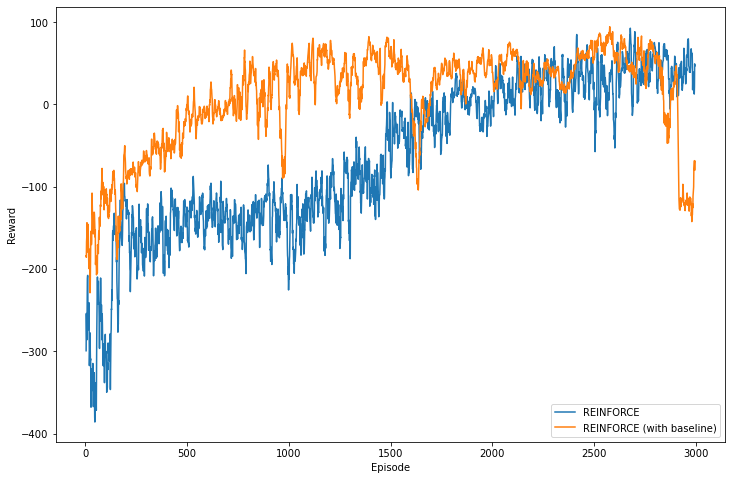

In [20]:
if training:
    results = Results()
    policy_learning_rate = 3e-3
    _, _ = run_experiment("REINFORCE", discrete_env, num_episodes, policy_learning_rate)
    episodes, _ = run_experiment("REINFORCE (with baseline)", discrete_env, num_episodes, policy_learning_rate, 
                                 baseline='simple')
    results.save('rl-simple-baseline')
else:
    results = Results(filename='rl-simple-baseline.npz')
    results.plot(plot_window)

In [21]:
if render_landing:
    render(episodes[-1], discrete_env)

**Question 1**: We have at least three posibilities of picking the action: i) sample an action according to the softmax distribution, ii) select action with max action probability and iii) use an epsilon-greedy strategy. What is the difference between these strategies and which one(s) is(are) preferable during training and which one(s) is(are) preferable during testing?. 


**Answer**: The second option ii) does not take action randomly while the two others are.  Softmax or epsilon-greedy for training because it allows to explore more state. For testing we use max prop as we are not anymore in the exploration phase and we want to maximize our reward.

**Question 2**: In the train method above we throw away the data from an episode after we use it to train the network (make sure that you do that). Why is it not a good idea to keep the old episodes and train the policy network on both old and new data? (Note: Reusing data can still be possible but requires modifications to the REINFORCE algorithm that we are using).

**Answer**: We'll overfitting the past episode as they appear a lot more often during training. It will also make the training time longer. Maybe to solve the first issue we could give a lower weight to past episodes.

## Exercise 2: Adaptive baseline
### Description

Add a second neural network to your model that learns an observations-dependent adaptive baseline and subtracts it from your discounted returns.

1. Modify the `_build_network` function of RLAgent to create a second "value network" when `adaptive` is passed for the baseline argument. The value network should have the same or similar structure as the policy network, without the softmax at the output.
3. In addition to training your policy network, train the value network on the Mean-Squared Error compared to the discounted returns.
4. Train your policy network on $R - b(s)$, i.e. the returns minus the adaptive baseline (the output of the value network). Your implementation should allow for a different learning rate for the value and policy network.
5. Try a few learning rates and plot all your best results together (without baseline, with simple baseline, with adaptive baseline). You may or may not be able to improve on the simple baseline! Return the trained model to use it in the next exercise.

TECHNICAL NOTE: Some textbooks may refer to this approach as "Actor-Critic", where the policy network is the "Actor" and the value network is the "Critic". Sutton and Barto (2018) suggest that Actor-Critic only applies when the discounted returns are bootstrapped from the value network output, as you saw in class. This can introduce instability in learning that needs to be addressed with more advanced techniques, so we won't use it for this miniproject. You can read more about state-of-the-art Actor-Critic approaches here: https://arxiv.org/pdf/1602.01783.pdf

**Mark breakdown: 3 points total**
- 3 points for implementing and plotting the adaptive baseline with the other two conditions, with reasonable performance (i.e. at least similar to the performance in Exercise 1).

### Solution

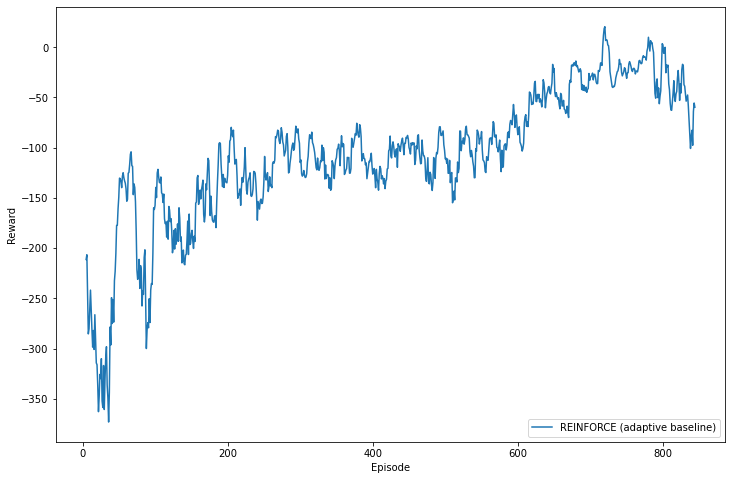

In [ ]:
if training:
    results = Results()
    policy_learning_rate = 3e-3
    value_learning_rate = 5e-3
    episodes, d_model = run_experiment("REINFORCE (adaptive baseline)", discrete_env, num_episodes, policy_learning_rate, 
                                   value_learning_rate, baseline='adaptive')
    results.save('rl-adaptive-baseline')
else:
    results = Results(filename='rl-adaptive-baseline.npz')
    results.plot(plot_window)

In [15]:
if render_landing:
    render(episodes[-1], discrete_env)

## Exercise 3: Visualizing the Value Function

### Description

Ideally, our value network should have learned to predict the relative values across the input space. We can test this by plotting the value prediction for different observations.

1. Write a function to plot the value network prediction across [x,y] space for given (constant) values of the other state variables. X is always in [-1,1], and Y generally lies in [-0.2,1], where the landing pad is at [0,0]. (`plt.imshow`, `plt.title`, and `plt.colorbar` can be useful)
2. Plot (with titles specifying the state variable combinations) the values for 5-6 combinations of the other 6 state variables, including [0,0,0,0,0,0]. The X and Y velocity are generally within [-1,1], the angle is in [-pi,pi] and the angular velocity lies roughly within [-3,3]. The last two inputs indicating whether the legs have touched the ground are 0 (False) or 1 (True). Include two combinations with (one of the) state variables out of these ranges. Use the same color bar limits across the graphs so that they can be compared easily. 
3. Answer the question below in max. 2-3 sentence(s).

**Mark breakdown: 3 points total**
- 3 points for the plots of the value function and answering the question below.

### Solution

In [140]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot(x, y, state, value_function, ax, vmin=None, vmax=None):
    """
    Input: 
    - x, y: arrays containing values for which we want to evaluate the value_function
    - value_function: the function to be evaluate for all pairs of value from x and y
    - state: a list of length 6 containing the other state variable required to evalute the value_function
    - ax: an axis on which we make the plot
    - vmin, vmax, range of values to display on the plot
    
    Plot the value network prediction across [x,y] space for given (constant) values of the other state variables "state".
    """
    

            
    # create an input matrix of size (len(x)*len(y), 8) to be fed to the value_function method
    y_ = np.repeat(y,len(x))
    x_ = x.copy()
    x_ = x_[list(np.arange(len(x_)))*len(y)]

    input_space = np.zeros((len(x) * len(y),8 ))
    
    input_space[:,0] = x_
    input_space[:,1] = y_
    input_space[:,2:] = state

    res = value_function(input_space).reshape((len(y),len(x)))

    ax.set_xticks(np.arange(len(x),step=10))
    ax.set_yticks(np.arange(len(y),step=10))
    ax.set_xticklabels(x[:: 10].round(1))
    ax.set_yticklabels(y[:: 10].round(1))
    ax.set_title("State: {0}".format(state), fontsize=25)
    ax.set_xlabel("x",fontsize=20)
    ax.set_ylabel("y",fontsize=20)

    im = ax.imshow(res,  vmin = vmin, vmax = vmax) 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    bounds = np.arange(-100,100)
    plt.colorbar(im, cax=cax)#, boundaries=np.linspace(-100,100,2),ticks=bounds[::15])


In [141]:
#define valid and invalid states
valid_states = [
    [0,0,0,0,0,0],
    [-0.5,1.5,0,-1,0,0],
    [-0.5,-1,3.14,-2,0,0],
    [1,0,-2,2,0,0]
]
invalid_states = [
    [0,-100,0,0,0,0],
    [0,0,0,100,0,0]
]

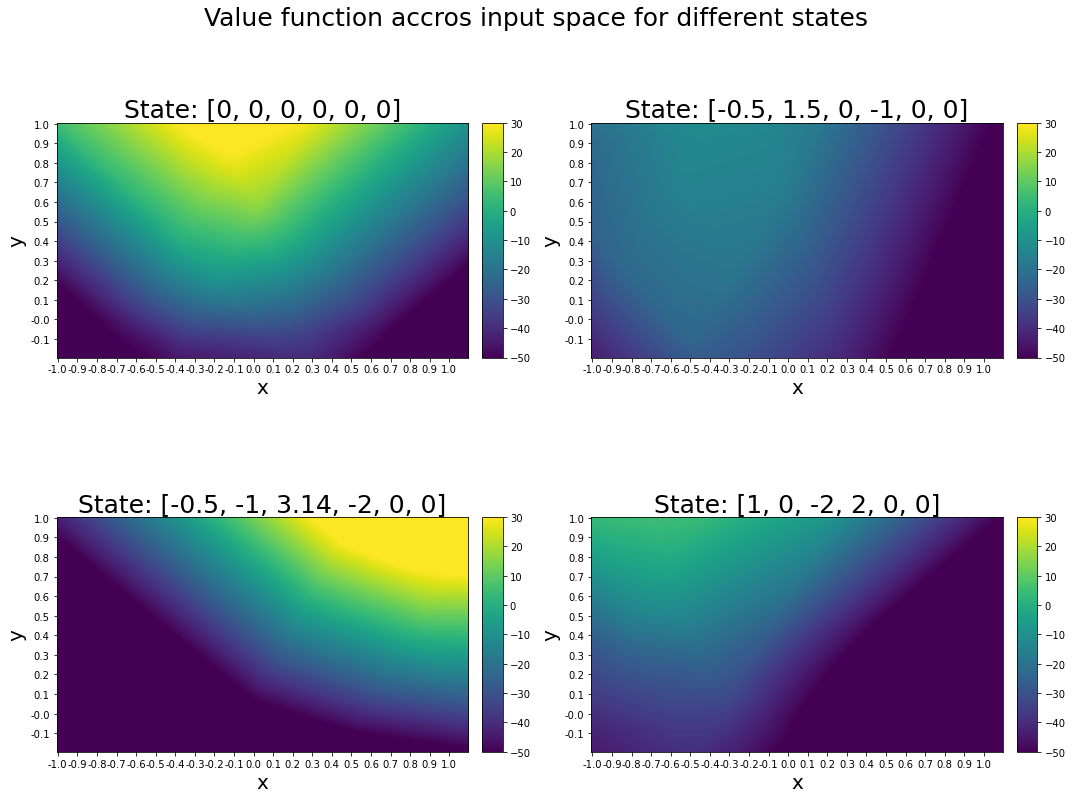

In [145]:
f = d_model.value_model.predict
x = np.arange(-1,1.1,0.01)
y = np.arange(1,-0.2,-0.01)
vmin = -50
vmax = 30
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Value function accros input space for different states", fontsize=25)
for ax, state in zip(axes.flatten(), valid_states):
    plot(x,y,state,f,ax, vmin, vmax)   
fig.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

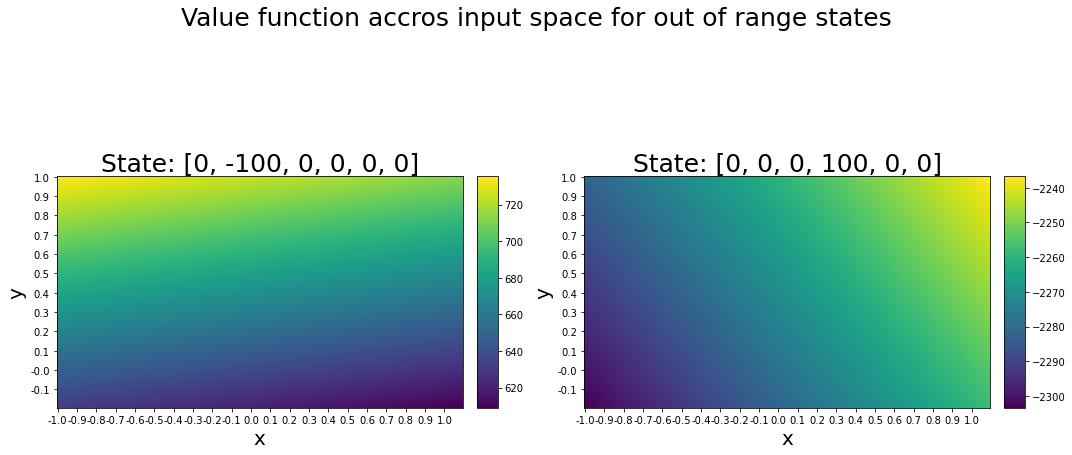

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle("Value function accros input space for out of range states", fontsize=25)
for ax, state in zip(axes.flatten(), invalid_states):
    plot(x,y,state,f,ax)   
fig.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

**Question**: Does your value map for the state variables combination [0,0,0,0,0,0] make sense? What about the value maps for the combinations with state variables out of the ranges above?

**Answer**:
For the combination of [0,0,0,0,0,0] i.e. the first plot, the plot makes sense. The higher we are (considering the y value) the more reward we might accumulate. Also the more we deviate from x=0 by going too much on the left or too much on the right the less reward we might accumulate. 
From the out of range variable we see extreme values predicted by network. This also makes sense as we didn't train using these kind of states. I.e. our function only makes sense in the range that it has been trained on.

## Exercise 4: Comparing Architectures
### Descrition

Choosing a good neural network architecture is always a tricky question - on one hand, you want a complex architecture that is flexible enough to be able to solve the task, and on the other hand, you want to train your network as fast as possible and to not overuse your computational power. In the previous sections, we asked you to create a network with 3 hidden layers which you saw that is able to successfully solve the task and play the game. What happens if we do the same with 1 or 2 hidden layers? In this exercise, we ask you to look into the effect of the architecture and to compare different models with each other.

1. Include an extra parameter `num_layers` in the RLAgent class (by default it is equal to 3).
2. Change the `_build_network` function so that it creates a policy and value networks with the required number of layers.
3. Compare (on the same axes) the resulting plots for num_layers = 1, 2, 3.

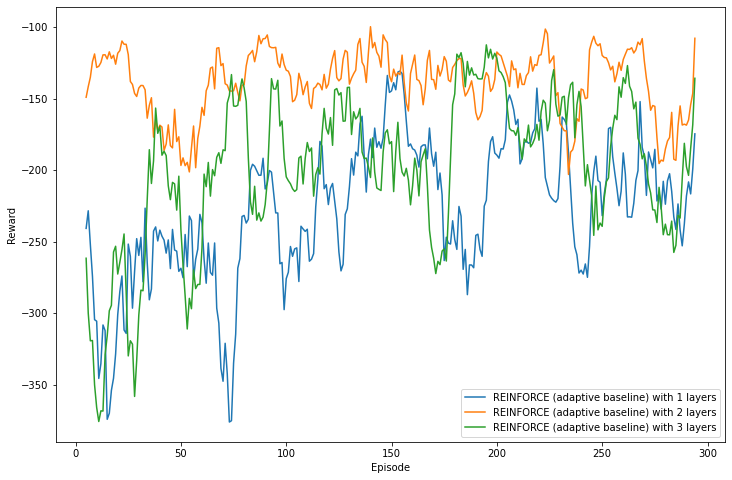

In [14]:
depths = [1, 2, 3]

if training:
    
    results = Results()
    policy_learning_rate = 2e-3
    value_learning_rate = 2e-3
    
    for d in depths:
        run_experiment("REINFORCE (adaptive baseline) with {} layers".format(d), 
                       discrete_env, num_episodes, 
                       policy_learning_rate, 
                       value_learning_rate, 
                       policy_num_layers=d,
                       value_num_layers=d,
                       baseline='adaptive')
        
    results.save('rl-res3')
    
else:
    results = Results(filename='rl-res3.npz')
    results.plot(plot_window)

## For your Interest..

The code you've written above can be easily adapted for other environments in Gym. If you like, try playing around with different environments and network structures!